# 1 Setup

In [0]:
import tensorflow as tf
tf.enable_eager_execution()

import tensorflow_hub as hub
import cv2
import numpy as np
import time
import glob

In [0]:
from tensorflow.data import Dataset
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [0]:
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
import tensorflow.keras.backend as K

In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2 Building the dataset (with tf.data.dataset API)

In [0]:
image_files= []
image_labels = []

# maybe make more flexible by reading categories automatically from folder.
for index, category in enumerate(['car','plane','train']): 
  
  category_image_files = (glob.glob("drive/My Drive/xylosai/tensorflow/images/{0}/*.jpg".format(category)) 
    +glob.glob("drive/My Drive/xylosai/tensorflow/images/{0}/*.jpeg".format(category))
    +glob.glob("drive/My Drive/xylosai/tensorflow/images/{0}/*.png".format(category)))
  image_files += category_image_files
  image_labels += ([index] * len(category_image_files))
  

In [80]:
# sanity check
print(len(image_files))
print(len(image_labels))
print(np.unique(image_labels))

515
515
[0 1 2]
515
515
[0 1 2]


In [0]:
# global variables
HEIGHT = 256
WIDTH = 256
CHANNELS = 3
NUM_CLASSES = 3
BATCH_SIZE = 20
EPOCHS = 5

In [0]:
def _parse_function(filename,label):
  image_string = tf.read_file(filename)
  image = tf.image.decode_jpeg(image_string,channels=CHANNELS)
  return image, label

def _resize(image, label):
  image_resized = tf.image.resize_images(image, [HEIGHT, WIDTH])
  return image_resized, label

def _normalize(image, label):
  return tf.div(image,255), label

def _expand(image, label):
  return tf.expand_dims(image, axis=0), label

def _onehot(image, label):
  onehot = tf.one_hot(label,NUM_CLASSES)
#   onehot = tf.expand_dims(onehot, axis = 0)
  return image, onehot

In [0]:
train_image_files, test_image_files, train_image_labels, test_image_labels = train_test_split(image_files, image_labels, test_size = 0.25, random_state = 0)

In [0]:
# Dataset.from_tensor_slices requires data that fits entirely in memory. For larget datasets, for example use a generator with Dataset.from_generator

train_dataset = Dataset.from_tensor_slices((train_image_files,train_image_labels)).map(_parse_function).map(_resize).map(_normalize).map(_onehot)#.map(_expand)
test_dataset = Dataset.from_tensor_slices((test_image_files,test_image_labels)).map(_parse_function).map(_resize).map(_normalize).map(_onehot)#.map(_expand)


In [91]:
train_dataset.batch(20).output_shapes

(TensorShape([Dimension(None), Dimension(256), Dimension(256), Dimension(3)]),
 TensorShape([Dimension(None), Dimension(3)]))

# 3 Building and training the model (with Eager execution)

In [0]:
def ModelCarPlaneTrain(input_shape = (256,256,3), classes = 3):
    
    X_input = Input(input_shape)
    
    X = Conv2D(160,(4,4),strides = (1,1),name='conv1',kernel_initializer = glorot_uniform(seed=0))(X_input)
    X = Activation('relu')(X)
    X = MaxPooling2D((8, 8))(X)
    
    X = Conv2D(160,(2,2),strides = (1,1),name='conv2',kernel_initializer = glorot_uniform(seed=0))(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((4, 4))(X)
    
    X = Conv2D(80,(2,2),strides = (1,1),name='conv3',kernel_initializer = glorot_uniform(seed=0))(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((4, 4))(X)
    
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc', kernel_initializer = glorot_uniform(seed=0))(X)
    
    model = Model(inputs = X_input, outputs = X, name = 'ModelCarPlaneTrain')
    
    return model

In [0]:
model = ModelCarPlaneTrain()

optimizer = tf.train.AdamOptimizer()

In [99]:
start_time = time.time()

loss_history = []

for (batch, (images, labels)) in enumerate(train_dataset.batch(BATCH_SIZE).repeat(EPOCHS)):
  if (batch % 1 == 0):
    print(batch)
  with tf.GradientTape() as tape:
    logits = model(images)
    #default reduction of this loss function is Reduction.SUM_BY_NONZERO_WEIGHTS
    #see documentation https://www.tensorflow.org/api_docs/python/tf/losses/Reduction
    #this is relevant for evaluating the model in Eager with the dataset API. 
    loss_value = tf.losses.softmax_cross_entropy(labels, logits)
  
  loss_history.append(loss_value.numpy())
  grads = tape.gradient(loss_value, model.variables)
  optimizer.apply_gradients(zip(grads, model.variables), global_step = tf.train.get_or_create_global_step())
  
print("fitting took {0} seconds".format(time.time()-start_time))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
fitting took 610.9863970279694 seconds


Text(0,0.5,'Loss [entropy]')

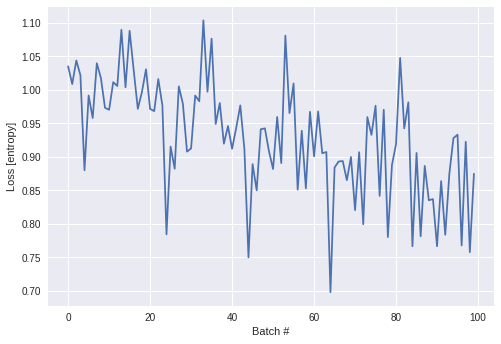

In [100]:
plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')

In [101]:
loss_value

<tf.Tensor: id=322902, shape=(), dtype=float32, numpy=0.8745043>

# 4 Evaluating the model

In [102]:
start_time = time.time()

loss_history = []

for (batch, (images, labels)) in enumerate(test_dataset.batch(BATCH_SIZE)):
  if (batch % 1 == 0):
    print(batch)
    logits = model(images)
    #default reduction of this loss function is Reduction.SUM_BY_NONZERO_WEIGHTS
    #see documentation https://www.tensorflow.org/api_docs/python/tf/losses/Reduction
    #this is relevant for evaluating the model in Eager with the dataset API. 
    loss_value = tf.losses.softmax_cross_entropy(labels, logits)
  
  loss_history.append(loss_value.numpy())

#This is mathematically correct thanks to Reduction.SUM_BY_NONZERO_WEIGHTS
mean_loss = sum(loss_history)/float(len(loss_history)) 
  
print("evaluating took {0} seconds".format(time.time()-start_time))
print("mean loss is {0}".format(mean_loss))

0
1
2
3
4
5
6
evaluating took 10.3053617477417 seconds
mean loss is 0.8483092359134129


Text(0,0.5,'Loss [entropy]')

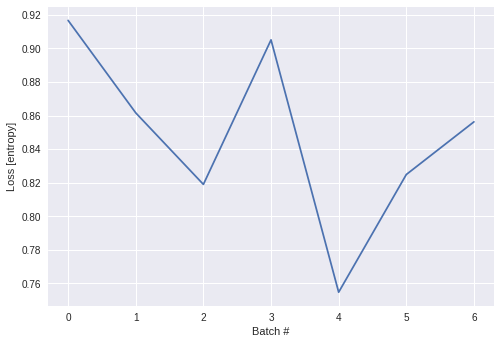

In [104]:
# not a very useful plot. We do not expect the loss to decrease wile evaluating
plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')